In [1]:
!pip install -U nilearn

    100% |████████████████████████████████| 901kB 8.2MB/s 
    100% |████████████████████████████████| 4.2MB 7.0MB/s 
  Running setup.py bdist_wheel for nilearn ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/ee/09/3c/6ddb63159d6377d2c1587e6b4d58a6456da4550c2248583ffc
  Running setup.py bdist_wheel for nibabel ... - \ | / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/46/50/8d/bcb0b8f7c030da5bac1752fbe9cc375cbf5725fa93ba79ad84
Successfully built nilearn nibabel


In [2]:
import warnings

import numpy as np
from scipy import stats
from sklearn.decomposition import FastICA

from nilearn import datasets
from nilearn.image import smooth_img

from nilearn.datasets import load_mni152_brain_mask
from nilearn.input_data import NiftiMasker

from nilearn import plotting

from nilearn.datasets import fetch_neurovault
from nilearn.datasets.neurovault import basic_collection_terms, NotNull

/usr/local/lib/python3.6/dist-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_e

In [4]:
print("Fetching Neurovault images; "
      "if you haven't downloaded any Neurovault data before "
      "this will take several minutes.")
nv_data = fetch_neurovault(max_images=100, collection_terms=dict(basic_collection_terms(), DOI=NotNull()))

Fetching Neurovault images; if you haven't downloaded any Neurovault data before this will take several minutes.
fetch_neurovault: using default value of 100 for max_images. Set max_images to another value or None if you want more images.
Reading local neurovault data.
Already fetched 1 image
Already fetched 2 images
Already fetched 3 images
Already fetched 4 images
Already fetched 5 images
Already fetched 6 images
Already fetched 7 images
Already fetched 8 images
Already fetched 9 images
Already fetched 10 images
Already fetched 11 images
Already fetched 12 images
Already fetched 13 images
Already fetched 14 images
14 images found on local disk.
Reading server neurovault data.
Scroll collections: getting new batch: http://neurovault.org/api/collections/?limit=100&offset=0
Scroll collections: batch size: 100
Scroll images from collection 1194: getting new batch: http://neurovault.org/api/collections/1194/images/?limit=100&offset=0
Scroll images from collection 1194: batch size: 2
Downl

Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_1039/image_14117.nii.gz
Already fetched 48 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_1039/image_14118.nii.gz
Already fetched 49 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_1039/image_14119.nii.gz
Already fetched 50 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_1039/image_14120.nii.gz
Already fetched 51 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_1039/image_14121.nii.gz
Already fetched 52 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_1039/image_14122.nii.gz
Already fetched 53 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_1039/image_14124.nii.gz
Already fetched 54 images
On neurovault.org: 38 images matched query in collection 1039
Scroll images from collection 866: 

Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_866/image_12609.nii.gz
Already fetched 85 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_866/image_12610.nii.gz
Already fetched 86 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_866/image_12611.nii.gz
Already fetched 87 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_866/image_12612.nii.gz
Already fetched 88 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_866/image_12613.nii.gz
Already fetched 89 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_866/image_12614.nii.gz
Already fetched 90 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_866/image_12615.nii.gz
Already fetched 91 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_866/image_12616.nii.gz
Al

In [0]:
images = nv_data['images']

In [6]:
print("\nReshaping and masking images.\n")

with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)
    warnings.simplefilter('ignore', DeprecationWarning)

    mask_img = load_mni152_brain_mask()
    masker = NiftiMasker(
        mask_img=mask_img, memory='nilearn_cache', memory_level=1)
    masker = masker.fit()

    # Images may fail to be transformed, and are of different shapes,
    # so we need to transform one-by-one and keep track of failures.
    X = []
    is_usable = np.ones((len(images),), dtype=bool)

    for index, image_path in enumerate(images):
        # load image and remove nan and inf values.
        # applying smooth_img to an image with fwhm=None simply cleans up
        # non-finite values but otherwise doesn't modify the image.
        image = smooth_img(image_path, fwhm=None)
        try:
            X.append(masker.transform(image))
        except Exception as e:
            meta = nv_data['images_meta'][index]
            print("Failed to mask/reshape image: id: {0}; "
                  "name: '{1}'; collection: {2}; error: {3}".format(
                      meta.get('id'), meta.get('name'),
                      meta.get('collection_id'), e))
            is_usable[index] = False

# Now reshape list into 2D matrix, and remove failed images from terms
X = np.vstack(X)


Reshaping and masking images.



In [7]:
!pip install -U umap-learn

Requirement not upgraded as not directly required: scikit-learn>=0.16 in /usr/local/lib/python3.6/dist-packages (from umap-learn) (0.19.1)
Requirement not upgraded as not directly required: scipy>=0.19 in /usr/local/lib/python3.6/dist-packages (from umap-learn) (0.19.1)
    100% |████████████████████████████████| 1.9MB 12.9MB/s 
Requirement not upgraded as not directly required: numpy>=1.8.2 in /usr/local/lib/python3.6/dist-packages (from scipy>=0.19->umap-learn) (1.14.3)
    100% |████████████████████████████████| 15.8MB 2.1MB/s 
  Running setup.py bdist_wheel for umap-learn ... - done
  Stored in directory: /content/.cache/pip/wheels/3c/37/81/7d524766f1f6e20fdd5c113afd52b7006a0b01c985f2a43962
Successfully built umap-learn


In [0]:
import umap

In [9]:
embedding = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation').fit_transform(X)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:887: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn('WARNING: spectral initialisation failed! The eigenvector solver\n'


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

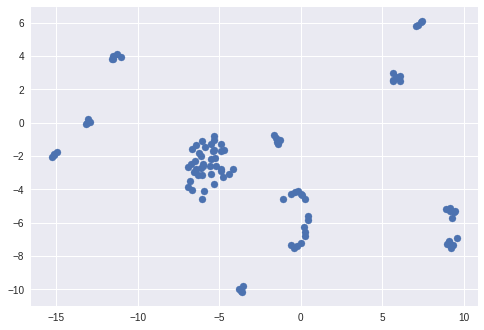

In [11]:
plt.scatter(embedding[:,0], embedding[:,1])